Access-Control Queuing Task
---
This is a decision task involving access control to a set of 10 servers. Customers of four different priorities arrive at a single queue. If given access to a server, the customers pay a reward of `1, 2, 4, or 8` to the server, depending on their priority, with higher priority customers paying more. In each time step, the customer at the head of the queue is either accepted (assigned to one of the servers) or rejected (removed from the queue, with a reward of zero). In either case, on the next time step the next customer in the queue is considered. The queue never empties, and the priorities of the customers in the queue are equally randomly distributed. Of course a customer cannot be served if there is no free server; the customer is always rejected in this case. Each busy server becomes free with probability `p = 0.06` on each time step.

The task is to decide on each step whether to accept or reject the next customer, on the basis of his priority and the number of free servers, so as `to maximize long-term reward without discounting`.

- State(num_servers, priority)
- Action(1, 0)
- Reward(1, 2, 4, 8)
---
<img src="differential_sarsa.png" width="600" style="float:left">

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from TileCoding import *

In [24]:
# possible priorities
PRIORITIES = np.arange(0, 4)
# reward for each priority
REWARDS = np.power(2, np.arange(0, 4))

# possible actions
REJECT = 0
ACCEPT = 1
ACTIONS = [REJECT, ACCEPT]

# total number of servers
NUM_OF_SERVERS = 10

# at each time step, a busy server will be free w.p. 0.06
PROBABILITY_FREE = 0.06

# step size for learning state-action value
ALPHA = 0.01

# step size for learning average reward
BETA = 0.01

# probability for exploration
EPSILON = 0.1

In [25]:
class ValueFunction:
    # In this example I use the tiling software instead of implementing standard tiling by myself
    # One important thing is that tiling is only a map from (state, action) to a series of indices
    # It doesn't matter whether the indices have meaning, only if this map satisfy some property
    # View the following webpage for more information
    # http://incompleteideas.net/sutton/tiles/tiles3.html
    # @alpha: step size for learning state-action value
    # @beta: step size for learning average reward
    def __init__(self, numOfTilings, alpha=ALPHA, beta=BETA):
        self.numOfTilings = numOfTilings
        self.maxSize = 2048
        self.hashTable = IHT(self.maxSize)
        self.weights = np.zeros(self.maxSize)

        # state features needs scaling to satisfy the tile software
        self.serverScale = self.numOfTilings / float(NUM_OF_SERVERS)
        self.priorityScale = self.numOfTilings / float(len(PRIORITIES) - 1)

        self.averageReward = 0.0

        # divide step size equally to each tiling
        self.alpha = alpha / self.numOfTilings

        self.beta = beta

    # get indices of active tiles for given state and action
    def getActiveTiles(self, freeServers, priority, action):
        activeTiles = tiles(self.hashTable, self.numOfTilings,
                            [self.serverScale * freeServers, self.priorityScale * priority],
                            [action])
        return activeTiles

    # estimate the value of given state and action without subtracting average
    def value(self, freeServers, priority, action):
        activeTiles = self.getActiveTiles(freeServers, priority, action)
        return np.sum(self.weights[activeTiles])

    # estimate the value of given state without subtracting average
    def stateValue(self, freeServers, priority):
        values = [self.value(freeServers, priority, action) for action in ACTIONS]
        # if no free server, can't accept
        if freeServers == 0:
            return values[REJECT]
        return np.max(values)

    # learn with given sequence
    def learn(self, freeServers, priority, action, newFreeServers, newPriority, newAction, reward):
        activeTiles = self.getActiveTiles(freeServers, priority, action)
        estimation = np.sum(self.weights[activeTiles])
        delta = reward - self.averageReward + self.value(newFreeServers, newPriority, newAction) - estimation
        # update average reward
        self.averageReward += self.beta * delta
        delta *= self.alpha
        for activeTile in activeTiles:
            self.weights[activeTile] += delta

In [38]:
vf = ValueFunction(3)
vf.getActiveTiles(10.3, 3, 1)

[0, 1, 2]

In [16]:
class ValueFunction:

    def __init__(self, alpha=0.01, numOfTilings=8, maxSize=2048):
        self.maxSize = maxSize
        self.numOfTilings = numOfTilings

        # divide step size equally to each tiling
        self.alpha = alpha / numOfTilings  # learning rate for each tile

        self.hashTable = IHT(maxSize)

        # weight for each tile
        self.weights = np.zeros(maxSize)

        # position and velocity needs scaling to satisfy the tile software
        self.serverScale = self.numOfTilings / 10.0  # 10 servers
        self.priorityScale = self.numOfTilings / 3.0  # 4 kinds of priorities

    # get indices of active tiles for given state and action
    def getActiveTiles(self, n_server, priority, action):
        activeTiles = tiles(self.hashTable, self.numOfTilings,
                            [self.serverScale * n_server, self.priorityScale * priority],
                            [action])
        return activeTiles

    # estimate the value of given state and action
    def value(self, state, action):
        n_server, priority = state
        activeTiles = self.getActiveTiles(n_server, priority, action)
        return np.sum(self.weights[activeTiles])

    # learn with given state, action and target
    def update(self, state, action, delta):
        n_server, priority = state
        activeTiles = self.getActiveTiles(n_server, priority, action)
        for activeTile in activeTiles:
            self.weights[activeTile] += delta*self.alpha

In [22]:
vf = ValueFunction()
vf.getActiveTiles(7, 14, 1)

[0, 1, 2, 3, 4, 5, 6, 7]

In [13]:
class ServerAcess:
    def __init__(self, exp_rate=0.3, lr=0.1, beta=0.1, alpha=0.1):
        self.n_server = 10
        self.free_prob = 0.06
        self.priorities = range(4)
        self.actions = [0, 1]  # 0: reject; 1: accept
        self.state = (0, 0)  # (num_servers, priority)
        
        self.exp_rate = exp_rate
        self.lr = lr
        self.beta = beta
        self.alpha = alpha
        
    def numFreeServers(self):
        n = 0
        n_free_server = self.state[0]
        n_busy_server = self.n_server - n_free_server
        for _ in range(n_busy_server):
            if np.random.uniform(0, 1) <= 0.06:
                n += 1
        n_free_server += n
        self.state = (n_free_server, self.state[1])
        return n_free_server
    
    def chooseAction(self, valueFunc):
        n_free_server = self.numFreeServers()
        if n_free_server == 0:
            return 0
        if np.random.uniform(0, 1) <= self.exp_rate:
            action = np.random.choice(self.actions)
        else:
            values = {}
            for a in self.actions:
                v = valueFunc.value(self.state, a)
                values[a] = v
            action = np.random.choice([k for k, v in values.items() if v == max(values.values())])
        return action
    
    def nxtState(self, action):
        if action == 1:
            n_free_server = self.state[0] - 1
        else:
            n_free_server = self.state[0]
        priority = np.random.choice(self.priorities)
        self.state = (n_free_server, priority)
        return self.state
    
    def giveReward(self, action):
        # recieve a reward by taking the action
        if action == 1:
            priority = self.state[1]
            return np.power(2, priority)
        return 0
    
    def run(self, valueFunc, steps=100, debug=False):
        # updating average reward estimation along the way
        avg_reward = 0
        self.state = (10, np.random.choice(self.priorities))
        cur_state = self.state
        cur_action = self.chooseAction(valueFunc)  # n free server is also updated
        
        for _ in range(steps):
            new_state = self.nxtState(cur_action)
            reward = self.giveReward(cur_action)
            new_action = self.chooseAction(valueFunc)
            
            if debug:
                print("state {} action {} reward {}".format(cur_state, cur_action, reward))
            
            delta = reward - avg_reward + valueFunc.value(new_state, new_action) - valueFunc.value(cur_state, cur_action)
            avg_reward += self.beta*reward
            valueFunc.update(cur_state, cur_action, delta)
            
            cur_state = new_state
            cur_action = new_action

In [14]:
sa = ServerAcess(exp_rate=1)
vf = ValueFunction(8)
sa.run(vf, 10)

state (10, 2) action 1 reward 4
state (9, 2) action 0 reward 0
state (9, 0) action 0 reward 0
state (9, 3) action 1 reward 2
state (8, 1) action 0 reward 0
state (8, 2) action 0 reward 0
state (8, 3) action 0 reward 0
state (9, 2) action 0 reward 0
state (9, 2) action 0 reward 0
state (9, 3) action 1 reward 4


In [14]:
l = []
for _ in range(1000):
    s = sa.numFreeServers()
    l.append(s)

(array([563.,   0., 318.,   0., 101.,   0.,  17.,   0.,   0.,   1.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

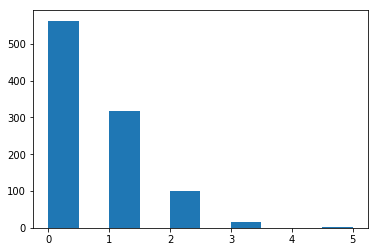

In [16]:
plt.hist(l)